# Práctico 3 - Procesamiento Digital de Imágenes

In [122]:
import imageio
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [123]:
MAT_RGB2YIQ = np.array([[0.299, 0.587, 0.114],
                        [0.596,-0.275,-0.321],
                        [0.211,-0.523, 0.311]])

def apply_matrix(img, M):
    return np.matmul(img.reshape((-1,3)), M.T).reshape(img.shape)

def rgb2yiq(img):
    return apply_matrix(img, MAT_RGB2YIQ)

def yiq2rgb(img):
    return apply_matrix(img, np.linalg.inv(MAT_RGB2YIQ))

def plot_hist(im, bins, ax, cumulative=False):
    counts, borders = np.histogram(im if im.ndim==2 else rgb2yiq(im)[...,0], bins=bins, range=(0,1))
    ax.bar(range(len(counts)), np.cumsum(counts) if cumulative else counts)
    #plt.xticks(ax.get_xticks(), labels=np.round(ax.get_xticks()/bins,2))
    #plt.grid(alpha=0.3)
    
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(np.round(ax.get_xticks()/bins,2))
    ax.grid(alpha=0.3)

Text(0.5, 1.0, 'Histograma de luminancia')

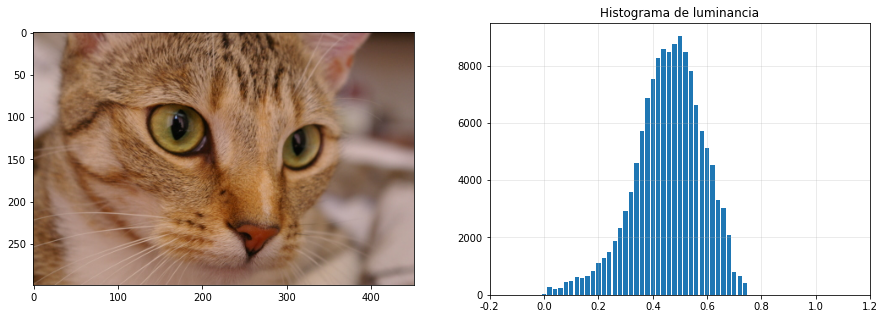

In [124]:
img_rgb = imageio.imread('imageio:chelsea.png')/255
img_gray = rgb2yiq(img_rgb)[:,:,0]

_, axes = plt.subplots(1, 2, figsize=(15,5))
axes[0].imshow(img_rgb)
plot_hist(img_rgb, 50, axes[1])
axes[1].set_title('Histograma de luminancia')

# 1. Normalizar histograma al rango [0,1]

Definir una función que normalice el histograma de valores de la imagen al rango [0,1]. Si la imagen es RGB, debe normalizar el histograma de luminancias.

Text(0.5, 1.0, 'Histograma de luminancia (normalizado [0,1])')

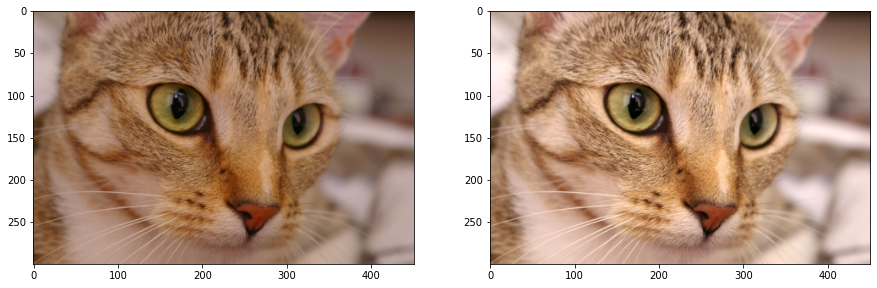

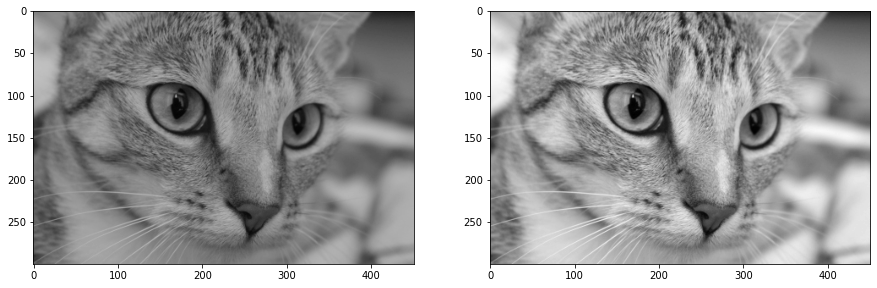

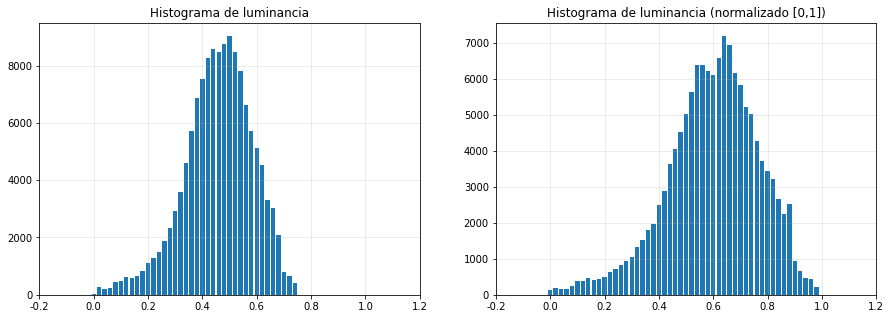

In [125]:
def norm_01(img):
    
    # si la imagen es rgb
    if img.ndim == 3:
        img_yiq = rgb2yiq(img)
        # normalizo [0,1]
        img_yiq[:,:,0] = (img_yiq[:,:,0] - img_yiq[:,:,0].min()) / (img_yiq[:,:,0].max() - img_yiq[:,:,0].min())
        
        return yiq2rgb(img_yiq)
    
    # si la imagen es gris
    else:
        # normalizo [0,1]
        img = (img - img.min()) / (img.max() - img.min())
        
        return img

# plots
fig, axes = plt.subplots(1, 2, figsize=(15,5))
axes[0].imshow(img_rgb)
axes[1].imshow(np.clip(norm_01(img_rgb), 0, 1))

fig, axes = plt.subplots(1, 2, figsize=(15,5))
axes[0].imshow(img_gray, 'gray', vmin=0, vmax=1)
axes[1].imshow(norm_01(img_gray), 'gray', vmin=0, vmax=1)

fig, axes = plt.subplots(1, 2, figsize=(15,5))
plot_hist(img_rgb, 50, axes[0])
plot_hist(norm_01(img_rgb), 50, axes[1])
axes[0].set_title('Histograma de luminancia')
axes[1].set_title('Histograma de luminancia (normalizado [0,1])')

## 1.1 Normalizar histograma usando percentiles

Definir una función que normalice el histograma de valores de la imagen de modo que el pixel del percentil P valga 0 y el pixel del percentil 100-P valga 1. Los valores entre los percentiles 0 y P valdrán 0 y los valores entre los percentiles 100-P y 100 valdrán 1. Si la imagen es RGB, normalizar el histograma de luminancias.

NOTA: para calcular percentiles usar np.percentile()

Text(0.5, 1.0, 'Histograma de luminancia (percenctil [1])')

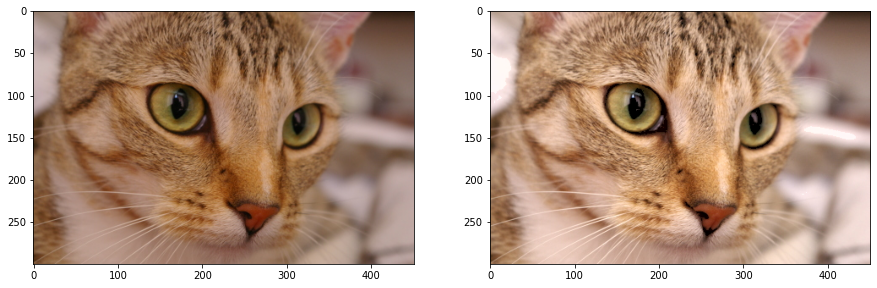

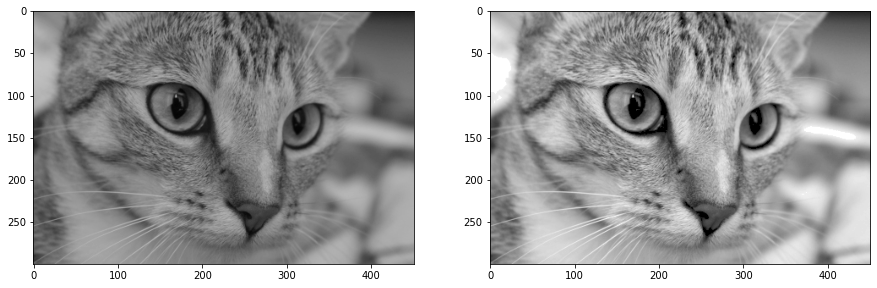

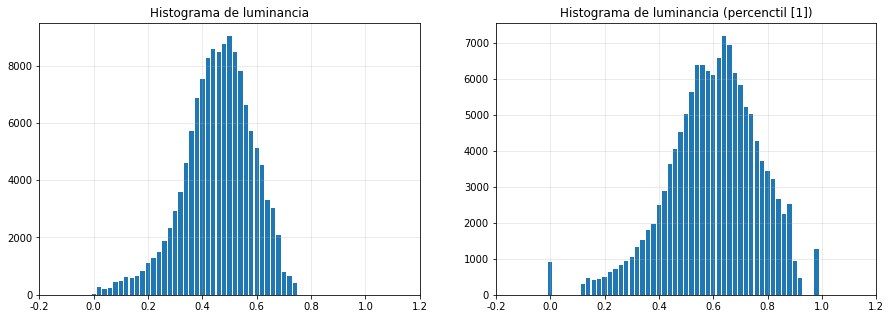

In [126]:
def norm_per(img, p):
    
    # si la imagen es rgb
    if img.ndim == 3:
        img_yiq = rgb2yiq(img)
       
        # normalizo [0,1]
        img_yiq[:,:,0] = (img_yiq[:,:,0] - img_yiq[:,:,0].min()) / (img_yiq[:,:,0].max() - img_yiq[:,:,0].min())
        
        # normalizo con percentil
        img_yiq[:,:,0][img_yiq[:,:,0] < np.percentile(img_yiq[:,:,0], p)] = 0
        img_yiq[:,:,0][img_yiq[:,:,0] > np.percentile(img_yiq[:,:,0], 100-p)] = 1
        
        return yiq2rgb(img_yiq)
    
    # si la imagen es gris
    else:
        # normalizo [0,1]# normalizo [0,1]
        img = (img - img.min()) / (img.max() - img.min())
        
        # normaliz con percentil
        img[img < np.percentile(img, p)] = 0
        img[img > np.percentile(img, 100-p)] = 1
        
        return img
    
per = 1

# plots
fig, axes = plt.subplots(1, 2, figsize=(15,5))
axes[0].imshow(img_rgb)
axes[1].imshow(np.clip(norm_per(img_rgb, per), 0, 1))

fig, axes = plt.subplots(1, 2, figsize=(15,5))
axes[0].imshow(img_gray, 'gray', vmin=0, vmax=1)
axes[1].imshow(norm_per(img_gray, per), 'gray', vmin=0, vmax=1)

fig, axes = plt.subplots(1, 2, figsize=(15,5))
plot_hist(img_rgb, 50, axes[0])
plot_hist(norm_per(img_rgb, per), 50, axes[1])
axes[0].set_title('Histograma de luminancia')
axes[1].set_title('Histograma de luminancia (percenctil [' + str(per) + '])')

## 2. Corrección gamma

1. Definir una función que aplique la corrección gamma a una imagen. Si la imagen es RGB, debe aplicar la corrección sobre la luminosidad de la imagen.
2. Normalizar la imagen al rango [0,1] (con min y max o con percentiles) y luego aplicar corrección gamma.


Como sugerencia, pasarle como parámetro un valor $\alpha$ de manera que $\gamma$ se calcule como:

$\gamma = 2^{-\alpha}$

De esta manera, cuando $\alpha=1 \rightarrow \gamma=1/2$, y cuando $\alpha=-1 \rightarrow \gamma=2$. Entonces, para $\alpha>0$ la luminosidad aumenta y para $\alpha<0$ disminuye.

Text(0.5, 1.0, 'Histograma de luminancia (corrección gamma [alpha=-2])')

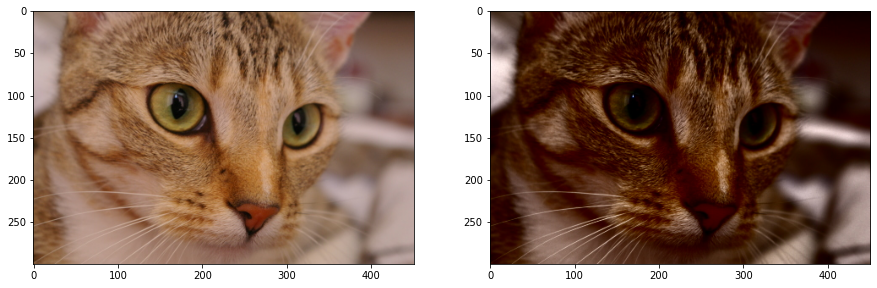

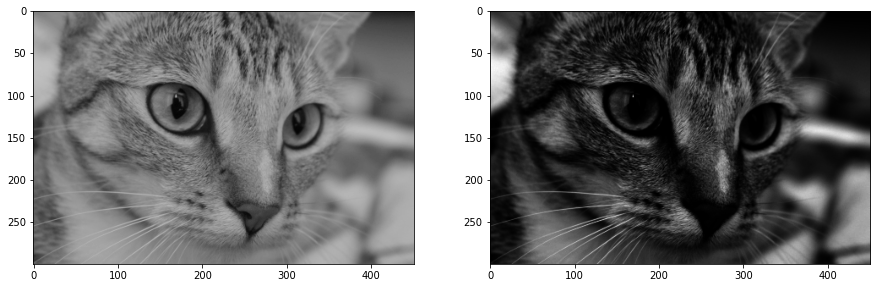

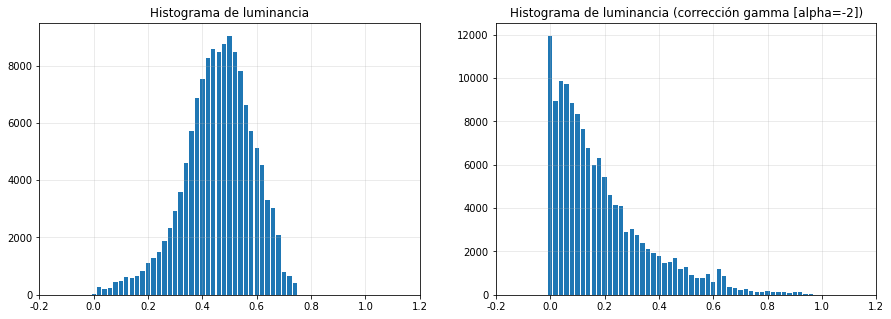

In [127]:
def gamma(img, alpha):
    
    g = 2**(-alpha) # gamma
    
    # si la imagen es rgb
    if img.ndim == 3:
        img_yiq = rgb2yiq(img)
        img_yiq[:,:,0] = img_yiq[:,:,0]**g # correción gamma
        
        return yiq2rgb(img_yiq)
     
    # si la imagen es gris
    else:
        img = img**g # correción gamma
      
        return img
        
a = -2

# plots
fig, axes = plt.subplots(1, 2, figsize=(15,5))
axes[0].imshow(img_rgb)
axes[1].imshow(np.clip(gamma(norm_01(img_rgb), a), 0, 1))
        
fig, axes = plt.subplots(1, 2, figsize=(15,5))
axes[0].imshow(img_gray, 'gray', vmin=0, vmax=1)
axes[1].imshow(gamma(norm_01(img_gray), a), 'gray', vmin=0, vmax=1)  # normalizo [0,1] y luego correción gamma 

fig, axes = plt.subplots(1, 2, figsize=(15,5))
plot_hist(img_rgb, 50, axes[0])
plot_hist(gamma(norm_01(img_rgb), a), 50, axes[1]) # normalizo [0,1] y luego correción gamma
axes[0].set_title('Histograma de luminancia')
axes[1].set_title('Histograma de luminancia (corrección gamma [alpha=' + str(a) + '])')

# 3. Modificación del histograma por una función definida a tramos

1. Definir una función que tome una imagen y dos arreglos $x$ e $y$ que definan una función no-lineal en el rango $0\leq x,y\leq 1$ y aplique la función a la intensidad de los pixeles de la imagen. Si la imagen es RGB debe aplicar la función a la luminosidad de la imagen.
2. Normalizar la imagen al rango [0,1] y luego aplicar corrección gamma.

Ayuda: La función np.interp() puede facilitarle la tarea

Text(0.5, 1.0, 'Histograma de luminancia (func. definida a tramos)')

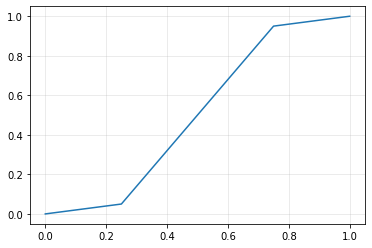

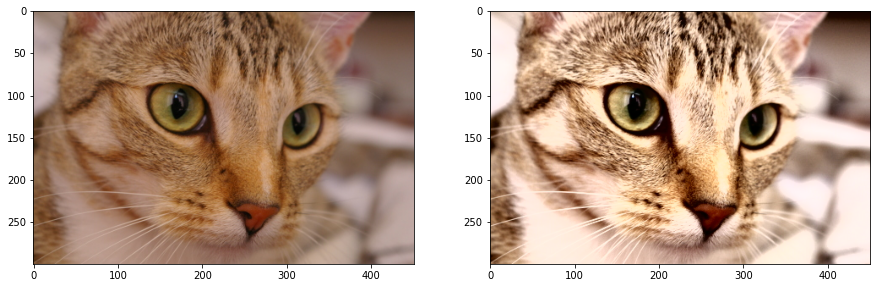

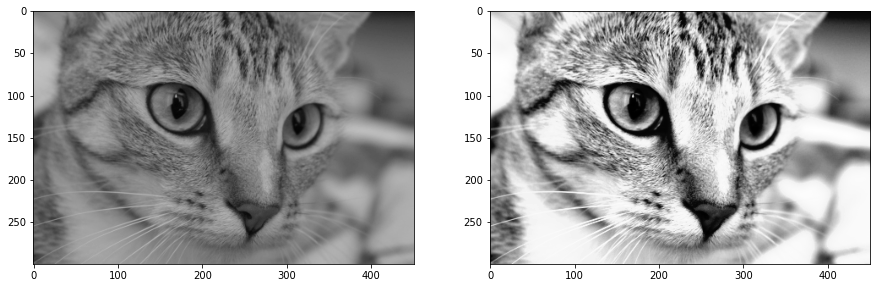

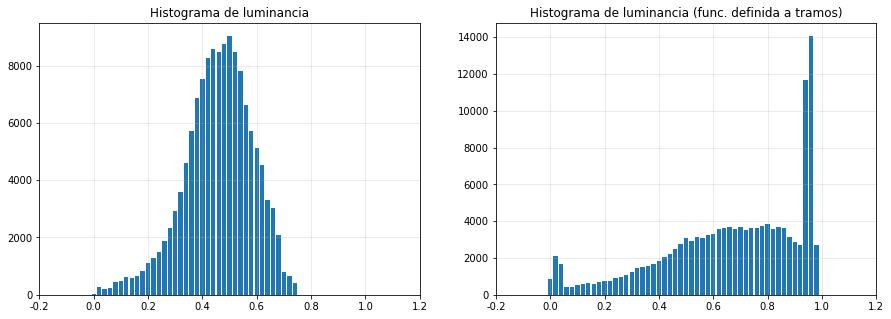

In [128]:
def func_tramos(img, x, y):
    
    # si la imagen es rgb
    if img.ndim == 3:
        img_yiq = rgb2yiq(img)
        img_yiq[:,:,0] = np.interp(img_yiq[:,:,0], x, y) # interpolación 
        
        return yiq2rgb(img_yiq)
    
    # si la imagen es gris
    else:
        img = np.interp(img, x, y) # interpolación
      
        return img

# función definida a tramos
x = np.array([0, 0.25,  0.75,  1])
y = np.array([0, 0.05, 0.95, 1])
plt.plot(x, y)
plt.grid(alpha=0.3)

# plots
fig, axes = plt.subplots(1, 2, figsize=(15,5))
axes[0].imshow(img_rgb)
axes[1].imshow(np.clip(func_tramos(norm_01(img_rgb), x, y), 0, 1))
        
fig, axes = plt.subplots(1, 2, figsize=(15,5))
axes[0].imshow(img_gray, 'gray', vmin=0, vmax=1)
axes[1].imshow(func_tramos(norm_01(img_gray), x, y), 'gray', vmin=0, vmax=1) # normalizo [0,1] y luego interpolación

fig, axes = plt.subplots(1, 2, figsize=(15,5))
plot_hist(img_rgb, 50, axes[0])
plot_hist(func_tramos(norm_01(img_rgb), x, y), 50, axes[1]) # normalizo [0,1] y luego interpolación
axes[0].set_title('Histograma de luminancia')
axes[1].set_title('Histograma de luminancia (func. definida a tramos)')

# 4. Uniformalización del histograma

1. Definir una función que tome una imagen y haga que su histograma de intensidades tenga una distribución uniforme. 
2. Normalizar el histograma al rango [0,1] y uniformalizar su distribución

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Histograma de luminancia (distribución uniforme)')

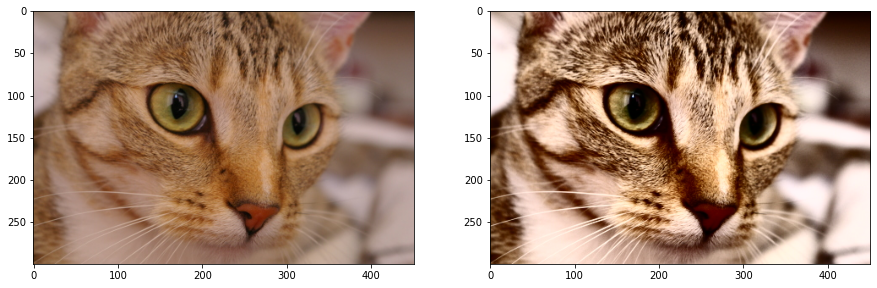

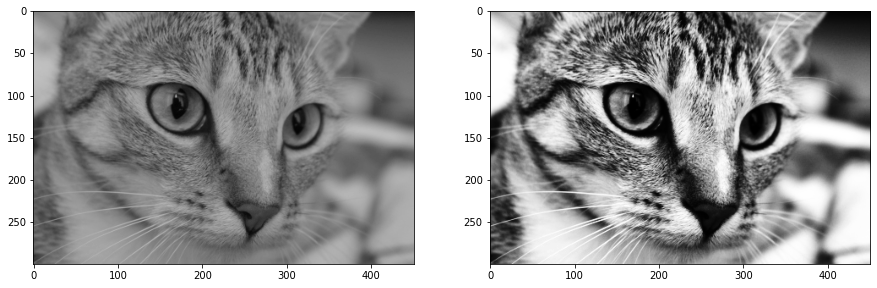

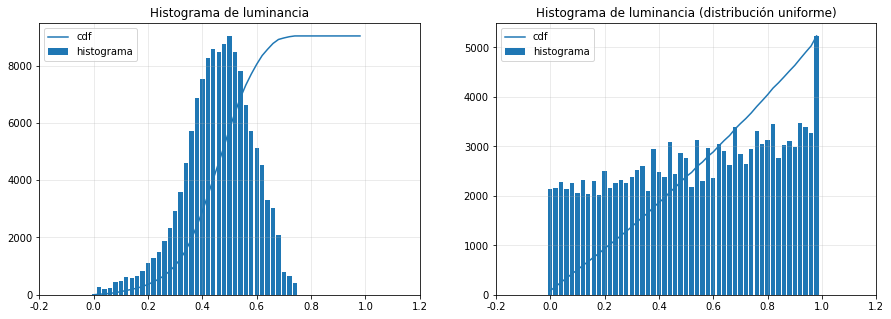

In [129]:
def dist_uniforme(img):
     
    # si la imagen es rgb    
    if img.ndim == 3:        
        
        img_yiq = rgb2yiq(img)
        
        # función de distribución acumulada CDF
        counts, borders = np.histogram((img_yiq[:,:,0]), bins=50, range=(0,1))
        cdf = counts.cumsum()
        cdf_norm = cdf * counts.max() / cdf.max()
        
        # cdf normalizado [0,1]
        cdf = cdf_norm / cdf_norm.max()
        
        # ecualización
        img_yiq[:,:,0] = np.interp(img_yiq[:,:,0], borders[:-1], cdf)
        
        # cdf imagen ecualizada
        counts, borders = np.histogram((img_yiq[:,:,0]), bins=50, range=(0,1))
        cdf = counts.cumsum()
        cdf_eq = cdf * counts.max() / cdf.max()
        
        return cdf_norm, cdf_eq, yiq2rgb(img_yiq)
    
    # si la imagen es gris
    else:
        
        # función de distribución acumulada CDF
        counts, borders = np.histogram((img), bins=50, range=(0,1))
        cdf = counts.cumsum()
        cdf_norm = cdf * counts.max() / cdf.max() # 
         
        # cdf normalizado [0,1] 
        cdf = cdf_norm / cdf_norm.max()
        
        # ecualización
        img_eq1 = np.interp(img, borders[:-1], cdf)
    
        # cdf de imagen ecualizada
        counts, borders = np.histogram((img_eq1), bins=50, range=(0,1))
        cdf = counts.cumsum()
        cdf_eq = cdf * counts.max() / cdf.max()
                
        return cdf_norm, cdf_eq, img_eq1
        
# plots
cdf, cdf_eq, img_eq = dist_uniforme(img_rgb)      
        
fig, axes = plt.subplots(1, 2, figsize=(15,5))
axes[0].imshow(img_rgb)
axes[1].imshow(img_eq) 

cdf, cdf_eq, img_eq = dist_uniforme(img_gray)

fig, axes = plt.subplots(1, 2, figsize=(15,5))
axes[0].imshow(img_gray, 'gray', vmin=0, vmax=1)
axes[1].imshow(img_eq, 'gray', vmin=0, vmax=1)

fig, axes = plt.subplots(1, 2, figsize=(15,5))
axes[0].plot(cdf) 
plot_hist(img_rgb, 50, axes[0])
axes[0].legend(['cdf','histograma'])
axes[1].plot(cdf_eq)
plot_hist(img_eq, 50, axes[1])
axes[1].legend(['cdf','histograma'])
axes[0].set_title('Histograma de luminancia')
axes[1].set_title('Histograma de luminancia (distribución uniforme)')

# 5. Normalización del histograma

1. Definir una función que tome una imagen y haga que su histograma de intensidades tenga una distribución normal. 
2. Normalizar el histograma al rango [0,1] y normalizar su distribución.

Indique desviación estándar: 0.15


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Histograma de luminancia (distribución normal)')

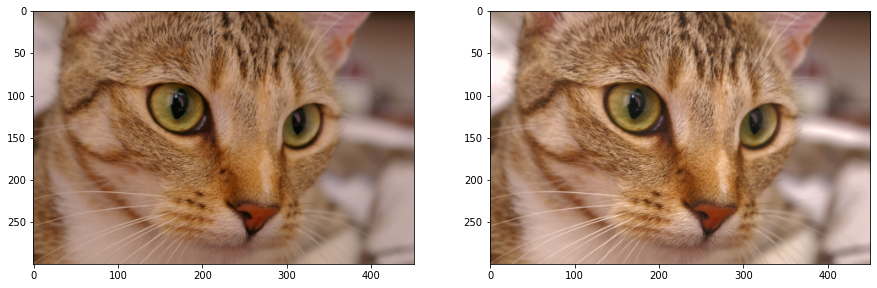

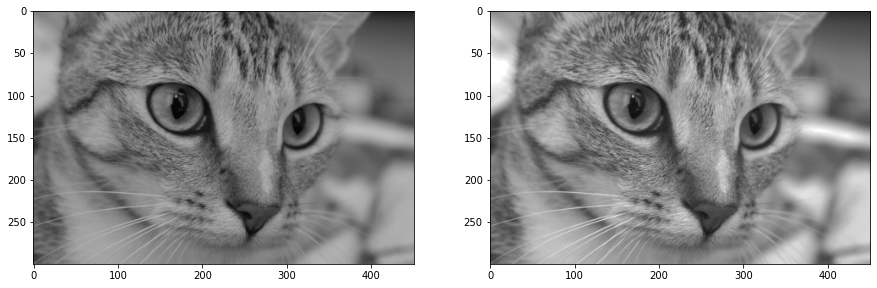

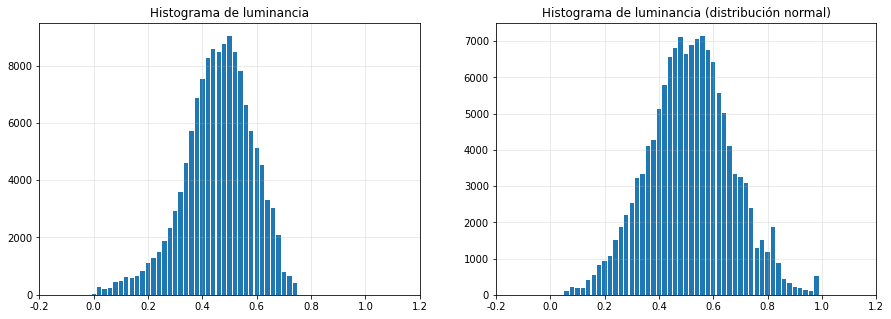

In [130]:
from scipy.stats import norm

norm.cdf(0.5)

def dist_normal(img, std):
     
    # si la imagen es rgb    
    if img.ndim == 3:        
        
        img_yiq = rgb2yiq(img)
        
        # cdf de distribución normal
        x = np.linspace(0.0, 1.0, 50)
        y = norm.cdf(x, 0.5, std)
        
        # imagen con distribución normal
        img_yiq[:,:,0] = np.interp(img_yiq[:,:,0], y, x)
        
        return yiq2rgb(img_yiq)
    
    # si la imagen es gris
    else:
        
        counts, borders = np.histogram((img), bins=50, range=(0,1))
        
        # cdf de distribución normal
        x = np.linspace(0.0, 1.0, 50)
        y = norm.cdf(x, 0.5, std)
        
        # imagen con distribución normal
        img_norm = np.interp(img, y, x)
        
        return img_norm

# std = 0.15
std = float(input('Indique desviación estándar: '))
    
#plots
cdf, cdf_eq, img_eq = dist_uniforme(img_rgb)
fig, axes = plt.subplots(1, 2, figsize=(15,5))
axes[0].imshow(img_rgb)
axes[1].imshow(dist_normal(img_eq,std)) 

cdf, cdf_eq, img_eq = dist_uniforme(img_gray)
fig, axes = plt.subplots(1, 2, figsize=(15,5))
axes[0].imshow(img_gray, 'gray', vmin=0, vmax=1)
axes[1].imshow(dist_normal(img_eq,std), 'gray', vmin=0, vmax=1)

fig, axes = plt.subplots(1, 2, figsize=(15,5))
plot_hist(img_rgb, 50, axes[0])
plot_hist(dist_normal(img_eq,std), 50, axes[1])
axes[0].set_title('Histograma de luminancia')
axes[1].set_title('Histograma de luminancia (distribución normal)')
